In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time as time

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras import layers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Dataset

In [3]:
df = pd.read_csv("./dataset/train.csv")
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (500000, 36)


,label,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0,1.721656,-2.026168,-1.678496,-0.517512,-0.567964,1.054221,0.069819,1.048858,0.832034,...,1.634686,0.849622,0.315492,-0.338898,-0.412601,1.027683,-1.542995,1.960504,-0.567663,-1.140047
1,0,1.596194,-1.577304,-0.706441,-1.553644,-1.173163,1.054221,0.125655,1.365986,0.756011,...,0.253726,0.901653,-0.305200,-0.221213,-1.351918,0.885052,-1.312088,-0.032521,-0.925837,-0.683991
2,0,2.096867,-0.477000,0.598374,0.239101,-0.209981,-0.850488,0.889856,0.811048,0.357467,...,1.544468,0.391239,1.085081,0.862539,-1.456647,-1.323906,-1.494468,0.947688,-0.288821,-0.364749
3,0,1.019743,-1.411434,-0.872602,0.153695,0.631471,-2.755198,-0.760561,0.143261,-1.253862,...,1.258645,-0.587911,0.110567,0.567624,-1.512797,-0.707736,-2.172718,0.045091,-0.345398,0.045562
4,0,0.877437,-0.507518,-0.818602,0.280093,-0.375073,0.005984,0.342253,0.964911,0.599365,...,0.955726,2.191106,0.429383,-1.432677,-0.407917,0.362277,-2.856638,1.672222,-0.617077,1.829777


In [4]:
X, y = df.iloc[:, 1:], df["label"]
print(f"X shape: {X.shape}, y shape: {y.shape}")

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) # random state can be modify
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True) # random state can be modify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")

X shape: (500000, 35), y shape: (500000,)
X_train shape: (450000, 35), y_train shape: (450000,)
X_valid shape: (50000, 35), y_valid shape: (50000,)


In [5]:
# Handling Outliers
# Calculate IQR
# Q1 = X_train.quantile(0.25)
# Q3 = X_train.quantile(0.75)
# IQR = Q3 - Q1

# # Defining bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Replacing outliers with the upper and lower bounds
# X_train = X_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
# X_valid = X_valid.clip(lower=lower_bound, upper=upper_bound, axis=1)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(450000, 35) (450000,)
(50000, 35) (50000,)


### Data Visualize

Label 0: 405041, Label 1: 44959
Imbalance scale: 9.009119419915923


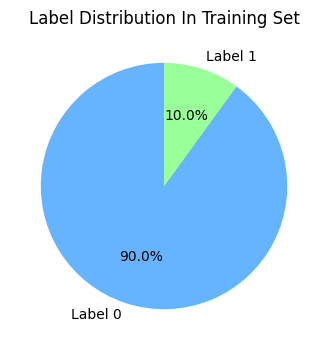

In [6]:
label_counts = np.bincount(y_train)
pos_sample = np.sum(y_train == 1)
neg_sample = np.sum(y_train == 0)
scale_weight = neg_sample / pos_sample
print(f"Label 0: {neg_sample}, Label 1: {pos_sample}")
print(f"Imbalance scale: {scale_weight}")

plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=['Label 0', 'Label 1'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution In Training Set')
plt.show()

Label 0: 44959, Label 1: 5041


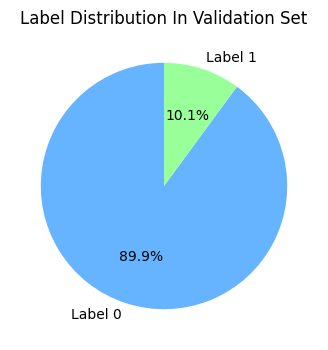

In [7]:
label_counts = np.bincount(y_valid)
pos_sample = np.sum(y_valid == 1)
neg_sample = np.sum(y_valid == 0)
print(f"Label 0: {neg_sample}, Label 1: {pos_sample}")

plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=['Label 0', 'Label 1'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution In Validation Set')
plt.show()

### Data preprocess

In [8]:
# # 卡方檢定
# scaler = MinMaxScaler()
# X_train_scale = scaler.fit_transform(X_train)
# X_valid_scale = scaler.transform(X_valid)

# # 選擇k個最佳特徵
# k =10
# chi2_selector = SelectKBest(chi2, k=k)
# chi2_selector.fit(X_train_scale, y_train)

# # 得到選擇的特徵
# selected_features = chi2_selector.get_support(indices=True)
# print(selected_features)
# X_train_selected = X_train_scale[:, selected_features]
# X_valid_selected = X_valid_scale[:, selected_features]
# print(X_train_selected.shape)

# # selected_feature_names.tolist()  # 顯示選擇的特徵名稱

In [9]:
# ratio = 0.9
# n_components = int(X_train.shape[1] * ratio)
# pca = PCA(n_components=n_components)
# X_train_pca = pca.fit_transform(X_train)
# X_valid_pca = pca.transform(X_valid)

# X_train_pca.shape, X_valid_pca.shape

In [10]:
# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_valid_std = sc.transform(X_valid)

In [11]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# label_counts = np.bincount(y_train_resampled)
# pos_sample = np.sum(y_train_resampled == 1)
# neg_sample = np.sum(y_train_resampled == 0)
# print(f"Label 0: {neg_sample}, Label 1: {pos_sample}")

# plt.figure(figsize=(4, 4))
# plt.pie(label_counts, labels=['Label 0', 'Label 1'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
# plt.title('Label Distribution In Resample Set')
# plt.show()

### Ensemble Model

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
xgb = XGBClassifier(
    # n_estimators=100, 
    max_depth=5, 
    # early_stopping_rounds=50,
    objective='binary:logistic', 
    reg_lambda=1.2, 
    min_child_weight=4,
    # eval_metric='auc',
    scale_pos_weight=2, # 1.5
    n_jobs=-1)

eval_set = [(X_train, y_train), (X_valid, y_valid)]

xgb.fit(X_train, y_train, eval_set=eval_set, verbose=10)

y_pred_train = xgb.predict(X_train)
y_pred_val =  xgb.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

[0]	validation_0-logloss:0.29836	validation_1-logloss:0.29903
[10]	validation_0-logloss:0.17746	validation_1-logloss:0.17892
[20]	validation_0-logloss:0.16706	validation_1-logloss:0.16954
[30]	validation_0-logloss:0.16339	validation_1-logloss:0.16678
[40]	validation_0-logloss:0.16106	validation_1-logloss:0.16575
[50]	validation_0-logloss:0.15947	validation_1-logloss:0.16536
[60]	validation_0-logloss:0.15793	validation_1-logloss:0.16517
[70]	validation_0-logloss:0.15612	validation_1-logloss:0.16461
[80]	validation_0-logloss:0.15455	validation_1-logloss:0.16411
[90]	validation_0-logloss:0.15295	validation_1-logloss:0.16389
[99]	validation_0-logloss:0.15169	validation_1-logloss:0.16375
F1-score on train: 0.8293657222997057
F1-score on valid: 0.8183780499539359


In [20]:
lgb = LGBMClassifier(
  # n_estimators=200, 
  max_depth=7, 
  num_leaves=101,
  min_child_samples=8,
  reg_lambda=1.2, 
  # early_stopping_rounds=20,
  # is_unbalance=True,
  scale_pos_weight=1.5,
  n_jobs=-1,
  verbose=10)

lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

y_pred_train = lgb.predict(X_train)
y_pred_val =  lgb.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

[LightGBM] [Info] Number of positive: 44959, number of negative: 405041
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.024947 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8790
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099909 -> initscore=-2.198237
[LightGBM] [Info] Start training from score -2.198237
[LightGBM] [Debug] Trained a tree with leaves = 101 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 97 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves 

In [24]:
cat = CatBoostClassifier(
    # depth=8,
    iterations=2000,
    class_weights=[1, 2],
    # early_stopping_rounds=100,
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0:1',
    verbose=True)

cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=10)

y_pred_train = cat.predict(X_train)
y_pred_val =  cat.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.031796
0:	learn: 0.6569235	test: 0.6574497	best: 0.6574497 (0)	total: 10.8ms	remaining: 21.5s
10:	learn: 0.6777771	test: 0.6761240	best: 0.6768645 (3)	total: 109ms	remaining: 19.6s
20:	learn: 0.6762779	test: 0.6758573	best: 0.6768645 (3)	total: 205ms	remaining: 19.3s
30:	learn: 0.6794510	test: 0.6804088	best: 0.6804088 (30)	total: 300ms	remaining: 19s
40:	learn: 0.6827910	test: 0.6832757	best: 0.6832757 (40)	total: 388ms	remaining: 18.5s
50:	learn: 0.6875295	test: 0.6869660	best: 0.6869660 (50)	total: 480ms	remaining: 18.3s
60:	learn: 0.6913707	test: 0.6921236	best: 0.6921236 (60)	total: 569ms	remaining: 18.1s
70:	learn: 0.6945088	test: 0.6978299	best: 0.6978299 (70)	total: 657ms	remaining: 17.9s
80:	learn: 0.6974472	test: 0.6996999	best: 0.6996999 (80)	total: 748ms	remaining: 17.7s
90:	learn: 0.6996765	test: 0.7012385	best: 0.7016115 (89)	total: 841ms	remaining: 17.7s
100:	learn: 0.7013105	test: 0.7028249	best: 0.7028249 (100)	total: 931ms	remaining: 17.5s
110:	

[('Feature 20', 0.007924216559363026), ('Feature 10', 0.07406020302040632), ('Feature 7', 0.09049457829242778), ('Feature 25', 0.10425528119033907), ('Feature 17', 0.10843823190515157), ('Feature 14', 0.15026171722767967), ('Feature 32', 0.15591753646969048), ('Feature 16', 0.1697073175073368), ('Feature 29', 0.17869350904947418), ('Feature 31', 0.18932210979129233), ('Feature 34', 0.19020425483682707), ('Feature 15', 0.19025556017357417), ('Feature 23', 0.19513768614853608), ('Feature 0', 0.20633415068190725), ('Feature 30', 0.21142366223836329), ('Feature 18', 0.25336888631487375), ('Feature 6', 0.26118459485167406), ('Feature 27', 0.3955982988557069), ('Feature 22', 0.5774042140461614), ('Feature 11', 0.5812561548596691), ('Feature 28', 0.654418124778494), ('Feature 4', 0.8045191829637348), ('Feature 8', 1.0374828979403272), ('Feature 26', 1.1123715738426365), ('Feature 24', 1.2332130038207025), ('Feature 21', 1.4097447064684696), ('Feature 33', 1.4919979088586068), ('Feature 5', 1.

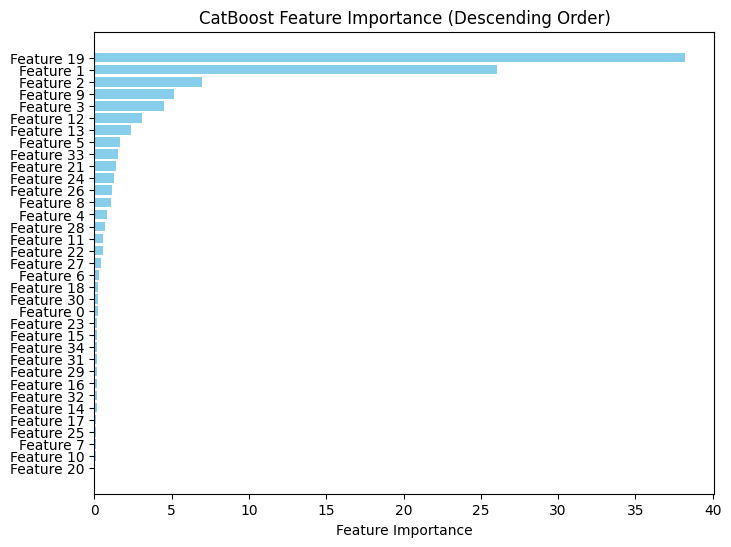

In [15]:
feature_importances = cat.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

features_importance_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1])
feature_names_sorted, feature_importances_sorted = zip(*features_importance_sorted)
print(features_importance_sorted)

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance (Descending Order)')
plt.show()

In [ ]:
threshold = 1

X_train_selected = X_train[:, feature_importances > threshold]
X_valid_selected = X_valid[:, feature_importances > threshold]

print(X_train_selected.shape)
print(X_valid_selected.shape)

In [54]:
cat = CatBoostClassifier(
    iterations=2000,
    class_weights=[1, scale_weight],
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0:1',
    verbose=True)

cat.fit(X_train_selected, y_train, eval_set=(X_valid_selected, y_valid), verbose=10)

y_pred_train = cat.predict(X_train_selected)
y_pred_val =  cat.predict(X_valid_selected)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.031796
0:	learn: 0.8355423	test: 0.8359051	best: 0.8359051 (0)	total: 9.65ms	remaining: 19.3s
10:	learn: 0.8477033	test: 0.8518331	best: 0.8518331 (10)	total: 96.6ms	remaining: 17.5s
20:	learn: 0.8523193	test: 0.8569103	best: 0.8569103 (20)	total: 183ms	remaining: 17.3s
30:	learn: 0.8562555	test: 0.8611966	best: 0.8611966 (30)	total: 272ms	remaining: 17.3s
40:	learn: 0.8591125	test: 0.8637531	best: 0.8639728 (39)	total: 360ms	remaining: 17.2s
50:	learn: 0.8617866	test: 0.8654583	best: 0.8654583 (50)	total: 449ms	remaining: 17.1s
60:	learn: 0.8643139	test: 0.8678552	best: 0.8680116 (58)	total: 537ms	remaining: 17.1s
70:	learn: 0.8658473	test: 0.8687833	best: 0.8689419 (69)	total: 625ms	remaining: 17s
80:	learn: 0.8667571	test: 0.8697130	best: 0.8697130 (80)	total: 714ms	remaining: 16.9s
90:	learn: 0.8679487	test: 0.8720779	best: 0.8720779 (90)	total: 802ms	remaining: 16.8s
100:	learn: 0.8687926	test: 0.8721715	best: 0.8723996 (91)	total: 889ms	remaining: 16.7s
110

In [ ]:
# y_pred_train_xgb = xgb.predict_proba(X_train)[:, 1]
# y_pred_val_xgb =  xgb.predict_proba(X_valid)[:, 1]
# y_pred_train_lgb = lgb.predict_proba(X_train)[:, 1]
# y_pred_val_lgb =  lgb.predict_proba(X_valid)[:, 1]
# y_pred_train_cat = cat.predict_proba(X_train)[:, 1]
# y_pred_val_cat =  cat.predict_proba(X_valid)[:, 1]

In [ ]:
# train_score = []
# valid_score = []

# threshold = 0.5
# coef_ = np.linspace(0,1,21)
# max_score = 0
# max_coef = [0, 0, 0]
# for i in coef_:
#     j_range = np.linspace(0, 1-i, 51)
#     for j in j_range:
#         k = 1 - i - j
#         print(f'Proportion (Model 1): {i}, Proportion (Model 2): {j}, Proportion (Model 3): {k}')
#         y_pred_train_final = (y_pred_train_xgb*i) + (y_pred_train_lgb*j) + (y_pred_train_cat*k)
#         y_pred_train_final = (y_pred_train_final > threshold).astype(int)
#         y_pred_valid_final = (y_pred_val_xgb*i) + (y_pred_val_lgb*j) + (y_pred_val_cat*k)
#         y_pred_valid_final = (y_pred_valid_final > threshold).astype(int)
#         train_score = f1_score(y_train, y_pred_train_final, average='macro')
#         valid_score = f1_score(y_valid, y_pred_valid_final, average='macro')
#         if(train_score + valid_score * 1.2> max_score ):
#             max_score = train_score + valid_score * 2
#             max_coef[0] = i
#             max_coef[1] = j
#             max_coef[2] = k
#         print(f'Combine train score: {train_score}')
#         print(f'Combine valid score: {valid_score}')

# print(max_coef)
# i, j, k = max_coef
# y_pred_train_final = (y_pred_train_xgb*i) + (y_pred_train_lgb*j) + (y_pred_train_cat*k)
# y_pred_train_final = (y_pred_train_final > threshold).astype(int)
# y_pred_valid_final = (y_pred_val_xgb*i) + (y_pred_val_lgb*j) + (y_pred_val_cat*k)
# y_pred_valid_final = (y_pred_valid_final > threshold).astype(int)
# train_score = f1_score(y_train, y_pred_train_final, average='macro')
# valid_score = f1_score(y_valid, y_pred_valid_final, average='macro')
# print(f'Combine train score: {train_score}')
# print(f'Combine valid score: {valid_score}')

In [25]:
xgb = XGBClassifier(
    # n_estimators=100, 
    max_depth=5, 
    # early_stopping_rounds=50,
    objective='binary:logistic', 
    reg_lambda=1.2, 
    min_child_weight=4,
    # eval_metric='auc',
    scale_pos_weight=2, # 1.5
    n_jobs=-1)

lgb = LGBMClassifier(
  # n_estimators=200, 
  max_depth=7, 
  num_leaves=101,
  min_child_samples=8,
  reg_lambda=1.2, 
  # early_stopping_rounds=20,
  # is_unbalance=True,
  scale_pos_weight=1.5,
  n_jobs=-1,
  verbose=10)
cat = CatBoostClassifier(
    # depth=8,
    iterations=2000,
    class_weights=[1, 2],
    # early_stopping_rounds=100,
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0:1',
    verbose=True)

voting = VotingClassifier(estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat)], voting='soft', n_jobs=-1, verbose=True)

voting.fit(X_train, y_train)

y_pred_train = voting.predict(X_train)
y_pred_val =  voting.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on train: 0.8281768996770766
F1-score on valid: 0.8211212338212722


### Evaluation

In [76]:
# y_pred_train = cat.predict(X_train_selected)
# y_pred_val =  cat.predict(X_valid_selected)
# # y_pred_train = xgb.predict(X_train)
# # y_pred_val =  xgb.predict(X_valid)
# # y_pred_train = lgb.predict(X_train)
# # y_pred_val =  lgb.predict(X_valid)

# # y_pred_prob_train = cat.predict_proba(X_train)[:, 1]
# # y_pred_prob_val = cat.predict_proba(X_valid)[:, 1]

# # threshold = 0.5
# # y_pred_train = (y_pred_prob_train > threshold).astype(int)
# # y_pred_val = (y_pred_prob_val > threshold).astype(int)

# print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
# print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on train: 0.8420441290909451
F1-score on valid: 0.822430549017847


### Submmit

In [26]:
df_test = pd.read_csv('./dataset/test.csv')

Id = df_test['id'].to_numpy()
X_test = df_test.iloc[:, 1:].to_numpy()
# X_test_std = sc.transform(X_test)
# X_test_selected = X_test_std[:, feature_importances > threshold]
print(f"X_test shape: {X_test.shape}")

X_test shape: (200000, 35)


In [27]:
X_test_scale = sc.transform(X_test)

print(X_test_scale.shape)

(200000, 35)


c:\Users\user\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [28]:
# Proportion (Model 1): 0.30000000000000004, Proportion (Model 2): 0.027999999999999997, Proportion (Model 3): 0.6719999999999999
# y_pred_test_xgb =  xgb.predict_proba(X_test)[:, 1]
# y_pred_test_lgb =  lgb.predict_proba(X_test)[:, 1]
# y_pred_test_cat =  cat.predict_proba(X_test)[:, 1]
# y_pred_test_final = (y_pred_train_xgb*0.3) + (y_pred_train_lgb*0.028) + (y_pred_train_cat*0.672)
# y_pred_test_final = (y_pred_test_final > threshold).astype(int)

In [29]:
# y_pred_test = cat.predict(X_test_scale)
y_pred_test = voting.predict(X_test_scale)

In [30]:
output_data = {'id': Id, 'label': y_pred_test}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)
print(output_dataframe['label'].value_counts())

output_dataframe.to_csv("./dataset/y_pred.csv", index=None)

            id  label
0            0      0
1            1      1
2            2      0
3            3      0
4            4      0
...        ...    ...
199995  199995      0
199996  199996      0
199997  199997      1
199998  199998      1
199999  199999      0

[200000 rows x 2 columns]
label
0    133093
1     66907
Name: count, dtype: int64
